In [1]:
import numpy as np
np.set_printoptions(precision=4)
from matplotlib import pyplot as plt

In [2]:
#Rastrigin function
def rastrigin(x_np_arr, A = 10):
    return np.array([A*x_np_arr.size + np.sum(np.power(x_np_arr, 2) - A*np.cos(np.deg2rad(2*x_np_arr*np.pi)))])

In [3]:
#Sphere function
def sphere(x_np_arr):
    return np.array([np.sum(np.power(x_np_arr, 2))])

In [4]:
#Rosenbrock function
def rosenbrock(x_np_arr):
    return np.array([np.sum(100 * np.power(x_np_arr[1:] - np.power(x_np_arr[:-1], 2), 2) + np.power(1 - x_np_arr[:-1], 2))])

In [5]:
#Queen bee original

class InitQueenBeeHive:
    def __init__(self, DIM, MIN, MAX, INDIVIDUALS, FUNCTION):
        self.DIM = DIM
        self.MIN = MIN
        self.MAX = MAX
        self.INDIVIDUALS = INDIVIDUALS
        self.FUNCTION = FUNCTION

    def __rastrigin(self, x_np_arr, A = 10):
        return np.array([A*self.DIM + np.sum(np.power(x_np_arr, 2) - A*np.cos(np.deg2rad(2*x_np_arr*np.pi)))])
    
    def __sphere(self, x_np_arr):
        return np.array([np.sum(np.power(x_np_arr, 2))])
    
    def __rosenbrock(self, x_np_arr):
        return np.array([np.sum(100 * np.power(x_np_arr[1:] - np.power(x_np_arr[:-1], 2), 2) + np.power(1 - x_np_arr[:-1], 2))])
    
    def populate(self):
        p = np.array([np.array([np.random.uniform(self.MIN, self.MAX) for _ in range(self.DIM)]) for _ in range(self.INDIVIDUALS)])
        if self.FUNCTION == 1:
            return np.hstack((p, [self.__rastrigin(x_np_arr) for x_np_arr in p]))
        elif self.FUNCTION == 2:
            return np.hstack((p, [self.__sphere(x_np_arr) for x_np_arr in p]))
        else:
            return np.hstack((p, [self.__rosenbrock(x_np_arr) for x_np_arr in p]))


In [6]:
def findQueenIndex(population):
    return np.argmin(population[:,-1:])

In [7]:
def tournamentSelection(pop_size, fitness, t_size, exclusion = -1):
    arr = np.random.choice(pop_size, t_size, replace=False)
    while np.isin(exclusion, arr):
        arr = np.random.choice(pop_size, t_size, replace=False)
    return int(np.argwhere(fitness == np.min(np.take(fitness, arr)))[0])

In [8]:
def findDrones(population, queenIdx):
    minDroneNumb = 1
    np2 = int(population[:,-1:].size // 2) + 1
    dronesNumber = np.random.randint(minDroneNumb, np2)
    drones = np.unique(np.array([tournamentSelection(population[:,-1:].size, population[:,-1:].flatten(), 3, queenIdx) for _ in range(dronesNumber)]))
    return drones

In [9]:
def linearCombinationCrossover(population, queenIdx, dronesIdx, linearCombinationRate):
    queen = np.take(population, queenIdx, axis=0)
    drones = np.take(population, dronesIdx, axis=0)
    children = queen + np.multiply(queen - drones, linearCombinationRate)
    children = np.delete(children, np.s_[-1:], axis=1)
    children = np.hstack((children, np.array([np.NINF for i in children])[:, None]))
    crossedPopulation = np.append(np.delete(population, dronesIdx, 0), children, 0)
    np.random.shuffle(crossedPopulation)
    return crossedPopulation

In [10]:
def mutation(combinedPopulation, xi, pm, psm, low, high, dim):
    rate = int(np.floor(xi * combinedPopulation[:,-1:].size))
    normalMutation = np.hstack((combinedPopulation[ : rate], [np.random.random_sample((1,)) for i in combinedPopulation[ : rate]]))
    normalMutation = np.where(pm < normalMutation[:, -1:], normalMutation, normalMutation + 
                              np.hstack((np.full((1, dim), np.random.uniform(low, high)).flatten(), np.array([np.NINF, np.NINF]))))
    strongMutation = np.hstack((combinedPopulation[ rate : ], [np.random.random_sample((1,)) for i in combinedPopulation[ rate : ]]))
    strongMutation = np.where(psm < strongMutation[:, -1:], strongMutation, strongMutation + 
                              np.hstack((np.full((1, dim), np.random.uniform(low, high)).flatten(), np.array([np.NINF, np.NINF]))))
    concat = np.delete(np.concatenate((normalMutation, strongMutation), axis=0), -1, axis=1)
    return concat

In [11]:
def evaluate(mutatedPopulation, function):
    infinityValues = np.where(mutatedPopulation[:, -1:] < 0)[0]
    toBeEvaluate = np.take(mutatedPopulation, infinityValues, axis=0)
    deletedInfinities = np.delete(mutatedPopulation, infinityValues, axis=0)
    toBeEvaluate = np.delete(toBeEvaluate, np.s_[-1:], axis=1)
    if function == 1:
        toBeEvaluate = np.hstack((toBeEvaluate, [rastrigin(x_np_arr) for x_np_arr in toBeEvaluate]))
    elif function == 2:
        toBeEvaluate = np.hstack((toBeEvaluate, [sphere(x_np_arr) for x_np_arr in toBeEvaluate]))
    else:
        toBeEvaluate = np.hstack((toBeEvaluate, [rosenbrock(x_np_arr) for x_np_arr in toBeEvaluate]))
    return np.concatenate((deletedInfinities, toBeEvaluate), axis=0)

In [12]:
DIM = 20
MIN = -5
MAX = 5
INDIVIDUALS = 500
XI = 0.8
linearCombinationRate = 0.5 #0-1 halves the distance at 0.5
pm = 0.05
psm = 0.8
low = -0.1
high = 0.1
functionNo = 2
generations = 5000

hive = InitQueenBeeHive(DIM, MIN, MAX, INDIVIDUALS, functionNo)
population = hive.populate()

queenArray = np.array([])
avgArray = np.array([])

for i in range(generations):
    queenIdx = findQueenIndex(population)
    queenArray = np.append(queenArray, population[queenIdx][-1:])
    avgArray = np.append(avgArray, np.average(population[-1:]))
    dronesIdx = findDrones(population, queenIdx)
    crossedPopulation = linearCombinationCrossover(population, queenIdx, dronesIdx, linearCombinationRate)
    mutatedPop = mutation(crossedPopulation, XI, pm, psm, low, high, DIM)
    population = evaluate(mutatedPop, functionNo)


[-0.0274  0.0018  0.0145  0.0006  0.0101 -0.0078  0.0428 -0.0079 -0.0204
  0.0144  0.0104 -0.0046 -0.0038  0.0168 -0.0157  0.0002 -0.0078  0.0113
 -0.0327  0.005   0.0056]


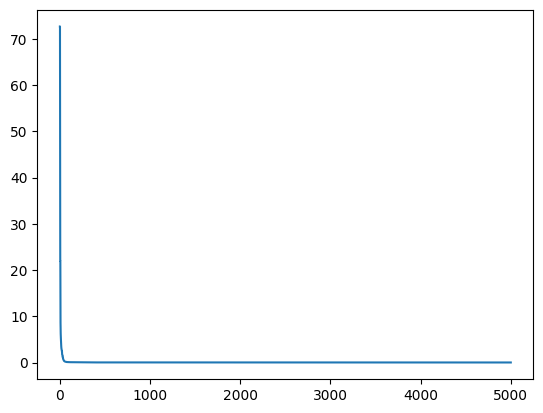

In [13]:
plt.plot(range(0, generations), queenArray)
#plt.plot(range(0, generations), avgArray)
queenIdx = findQueenIndex(population)
print(population[queenIdx])